In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import os
from PIL import Image
import warnings
import matplotlib.pyplot as plt
import pandas as pd
from torchviz import make_dot

warnings.filterwarnings("ignore")

全局变量

In [13]:
# 训练集，测试集图像地址：
train_test_img_loc=r'D:/COSMOS 2015 cataloge/003/results (18)/训练集_测试集/'
# 训练集标签的.txt文档：
train_label_txt='D:/COSMOS 2015 cataloge/003/results (18)/训练集.txt'
# 测试集标签的.txt文档：
test_label_txt='D:/COSMOS 2015 cataloge/003/results (18)/测试集.txt'
# 所有待预测图像所在的文件夹路径：
pre_doc_loc=r'D:/COSMOS 2015 cataloge/003/results (18)/待预测/'
#所有待预测图像名称的.txt文档
pre_name='D:/COSMOS 2015 cataloge/003/results (18)/待预测.txt'
# 结果导出位置：
c='D:/COSMOS 2015 catalog/003/results (18)/'

In [3]:
plt.ion()

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(84),
        # transforms.CenterCrop(84),
        # 转换成tensor向量
        transforms.ToTensor(), # 归一化
        # [0.485, 0.456, 0.406]，各通道的均值与标准差
        transforms.Normalize([0.5], [0.3])
    ]),
    'val': transforms.Compose([
        transforms.Resize(84),
       # transforms.CenterCrop(84),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.3])
    ]),
}

# 图像读入
def Load_Image_Information(path):
    # 图像存储路径，训练集，测试集涉及到的所有带标签的图像
    #image_Root_Dir= r'D:/COSMOS 2015 cataloge/2/cataloge/data/model/image_model'
    image_Root_Dir = train_test_img_loc
    # 获取图像的路径
    iamge_Dir = os.path.join(image_Root_Dir, path)
    # 以L格式打开图像
    # Pytorch DataLoader就是使用PIL所读取的图像格式
    return Image.open(iamge_Dir).convert('L')


class my_Data_Set(nn.Module):
    def __init__(self, txt, transform=None, target_transform=None, loader=None):
        super(my_Data_Set, self).__init__()
        fp = open(txt, 'r') # 打开存储图像名与标签的txt文件
        # fp = open('D:/download_By_Chome/data/acs_mosaic_2.0/index/index.txt', 'r')
        images = []
        labels = []
        # 将图像名和图像标签对应存储起来
        for line in fp:
            line.strip('\n')
            line.rstrip()
            information = line.split()
            images.append(information[0]+' '+information[1])
            labels.append(int(information[2]))
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    # 重写这个函数用来进行图像数据的读取
    def __getitem__(self, item):    # 实例对象通过[]运算符取值时，会调用它的方法__getitem__
        # 获取图像名和标签
        imageName = self.images[item]
        label = self.labels[item]
        # 读入图像信息
        image = self.loader(imageName)
        # 处理图像数据
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    # 重写函数，查看数据集中含有多少数据
    def __len__(self):
        return len(self.images)


In [4]:
'''
# 生成Pytorch所需的DataLoader数据输入格式
train_dataset = my_Data_Set('D:/download_By_Chome/data/acs_mosaic_2.0/index/训练集.txt', transform=data_transforms['train'], loader=Load_Image_Information)
test_dataset = my_Data_Set('D:/download_By_Chome/data/acs_mosaic_2.0/index/测试集.txt', transform=data_transforms['val'], loader=Load_Image_Information)
'''
# 生成Pytorch所需的DataLoader数据输入格式
train_dataset = my_Data_Set(train_label_txt, transform=data_transforms['train'], loader=Load_Image_Information)
test_dataset = my_Data_Set(test_label_txt, transform=data_transforms['val'], loader=Load_Image_Information)
'''
train_dataset = my_Data_Set('D:/COSMOS 2015 cataloge/2/cataloge/data/model/训练集.txt', transform=data_transforms['train'], loader=Load_Image_Information)
test_dataset = my_Data_Set('D:/COSMOS 2015 cataloge/2/cataloge/data/model/测试集.txt', transform=data_transforms['val'], loader=Load_Image_Information)
'''

"\ntrain_dataset = my_Data_Set('D:/COSMOS 2015 cataloge/2/cataloge/data/model/训练集.txt', transform=data_transforms['train'], loader=Load_Image_Information)\ntest_dataset = my_Data_Set('D:/COSMOS 2015 cataloge/2/cataloge/data/model/测试集.txt', transform=data_transforms['val'], loader=Load_Image_Information)\n"

In [5]:
# test_dataset = my_Data_Set('D:/download_By_Chome/data/acs_mosaic_2.0/index/val.txt', transform=data_transforms['val'], loader=Load_Image_Information)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)   # DataLoader()数据加载器。结合数据集和采样器，并提供给定数据集的可迭代对象。
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

# 验证是否生成DataLoader格式数据
for data in train_loader:
    inputs, labels = data
    print(inputs)
    print(labels)
for data in test_loader:
    inputs, labels = data
    print(inputs)
    print(labels)

# 定义CNN
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1,18,5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(18, 16, 5)
        self.fc1 = nn.Linear(16 * 18 * 18, 800)
        self.fc2 = nn.Linear(800, 120)
        self.fc3 = nn.Linear(120, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

net = Net()

#训练，n=220
cirterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.5)
for epoch in range(220):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()                        # 优化器清零
        outputs = net(inputs)
        loss = cirterion(outputs, labels)
        loss.backward()
        optimizer.step()                         #优化
        running_loss += loss.item()
        if i % 200 == 199:
            print('[%d %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('finished training!')

tensor([[[[ 0.9869,  1.2222,  1.5490,  ...,  1.5621,  1.3529,  1.3529],
          [ 1.4052,  0.9608,  1.1176,  ...,  1.5229,  1.2353,  0.6863],
          [ 1.5490,  1.3268,  0.5817,  ...,  1.5098,  1.2092,  0.4902],
          ...,
          [ 0.3464,  0.8039,  0.9477,  ...,  1.5490,  0.9216,  0.8431],
          [ 0.5686,  0.5686,  0.2418,  ...,  1.6144,  1.0784,  0.9739],
          [ 0.3464,  0.0719, -0.8824,  ...,  1.5098,  1.5752,  1.4052]]],


        [[[ 1.5229,  1.5229,  0.9608,  ...,  1.2614,  1.3660,  1.4183],
          [ 1.4967,  1.5359,  1.2614,  ...,  1.4967,  1.3660,  1.5490],
          [ 1.5752,  1.3922,  1.4575,  ...,  1.5229,  1.1699,  1.5098],
          ...,
          [ 1.3660,  1.6013,  1.5621,  ...,  1.1961,  1.3007,  1.2614],
          [ 1.2484,  1.4706,  1.4444,  ...,  1.3791,  1.3922,  1.4052],
          [ 1.2222,  1.1046,  1.5229,  ...,  1.3137,  1.6144,  1.5359]]],


        [[[ 0.7908,  1.1961,  1.1569,  ...,  0.6863,  0.7124,  0.9869],
          [ 1.3791,  0.921

In [6]:
#测试
correct = 0
total = 0
with torch.no_grad():
    '''禁用梯度计算。当不会调用 Tensor.backward() 时，减少原本需要 requires_grad=True的计算的内存消耗。在这种模式下，每次计算的结果都会有requires_grad=False 使输入有requires_grad=True 。这个上下文管理器是线程本地的；它不会影响其他线程中的计算。也起到装饰器的作用。
    '''
    for data in test_loader:    # test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)

        images, labels = data
        outputs = net(Variable(images))
        '''
在PyTorch0.4.0之后Variable 已经被PyTroch弃用
Variable不再是张量使用autograd的必要条件
只需要将张量的requires_grad设为True该张量就会自动支持autograd运算
在新版的PyTorch中Variable(tensor)和Varialbe(tensor, requires_grad)还能继续使用，但是返回的是tensor变量，而不是Variable变量
使用Variable.data的效果和使用tensor.data一样
诸如Variable.backward()，Variable.detach()，Varialbe.register_hook()等方法直接移植到了tensor上，在tensor上可以直接使用同名的函数
'''

        _, predicted = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 92 %


In [32]:
## 保存模型
torch.save({'model': net.state_dict()},'D:/COSMOS 2015 cataloge/003/运行结果/CNN.pth')

'''
# 读取模型
net=net()
state_dict = torch.load('model_name.pth')
net.load_state_dict(state_dict['model'])
'''

"\n# 读取模型\nnet=net()\nstate_dict = torch.load('model_name.pth')\nnet.load_state_dict(state_dict['model'])\n"

In [14]:
# 图像读入
class Data_Set(nn.Module):
    def __init__(self, txt, transform=None, target_transform=None, loader=None):
        super(Data_Set, self).__init__()
        # 打开存储图像名与标签的txt文件
        fp = open(txt, 'r')
        images = []
        labels = []
        # 将图像名和图像标签对应存储起来
        for line in fp:
            line.strip('\n')
            line.rstrip()
            information = line.split()
            images.append(information[0])
            labels.append(int(information[1]))
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    # 重写这个函数用来进行图像数据的读取
    def __getitem__(self, item):    # 实例对象通过[]运算符取值时，会调用它的方法__getitem__
        # 获取图像名和标签
        imageName = self.images[item]
        label = self.labels[item]
        # 读入图像信息
        image = self.loader(imageName)
        # 处理图像数据
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    # 重写函数，查看数据集中含有多少数据
    def __len__(self):
        return len(self.images)

def Load_Image(path):
    # 图像存储路径
    image_Dir= pre_doc_loc     # 所有待预测图像所在的文件夹路径
    # 获取图像的路径
    iamge_Dir = os.path.join(image_Dir, path)
    # 以L格式打开图像
    # Pytorch DataLoader就是使用PIL所读取的图像格式
    return Image.open(iamge_Dir).convert('L')

# 目标数据
obj_dataset = Data_Set(pre_name, transform=data_transforms['val'], loader=Load_Image)     #所有待预测图像名称.jpg
obj_loader = DataLoader(obj_dataset, batch_size=10, shuffle=True)

In [15]:
prediction=[]
with torch.no_grad():
    for data in obj_loader:
        images, labels = data
        outputs = net(Variable(images))
        __, predicted = torch.max(outputs.data, dim=1)
        # total += labels.size(0)
        # correct += (predicted == labels).sum()
        prediction.append(predicted)

In [34]:
pre=[]
for i in range(len(prediction)):
    for j in range(len(prediction[i])):
        pre.append(int(prediction[i][j]))
# print(len(pre))

count=0
for i in range(len(pre)):
    if pre[i]==1:
        count+=1
# print(count/len(pre))

print('在 {} 个图像中识别出 {} 个merger，占比 {:.2f} %'.format(len(pre),count,100*(count/len(pre))))

在 21445 个图像中识别出 2138 个merger，占比 9.97 %


In [18]:
loc = pre_doc_loc   # 所有待预测图像所在的文件夹路径


# 输出列表merger
lis=os.listdir(loc)   # 所有待预测图像所在的文件夹路径
merger=[]
for i in range(len(pre)):
    if pre[i]>0:
        merger.append(lis[i])


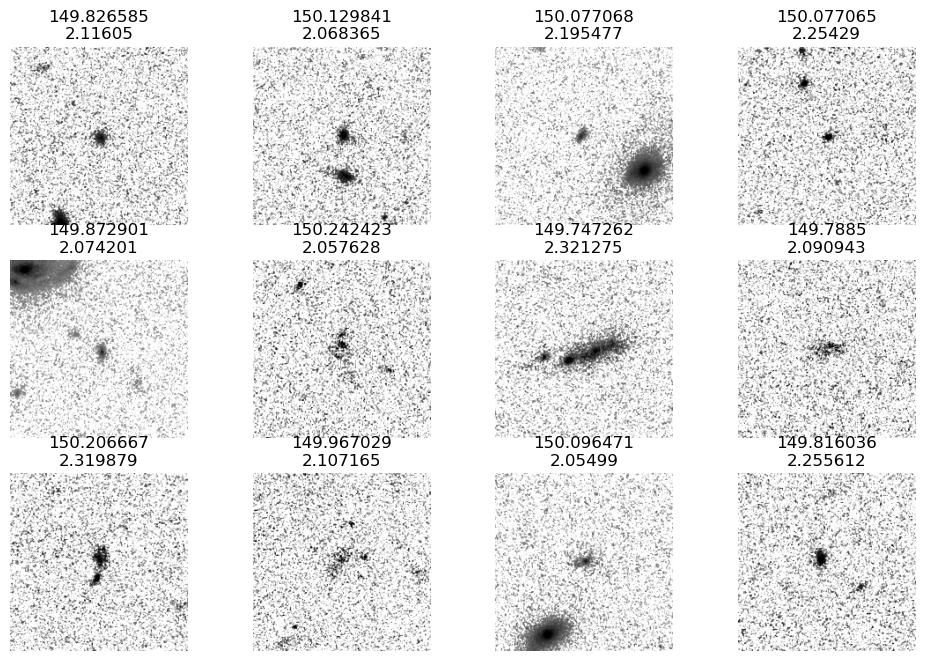

In [27]:
fig = plt.figure(figsize=(12,8),dpi=100)
for i in range(1,13):
    ax=fig.add_subplot(3,4,i)
    lo=merger[np.random.randint(1,len(merger))]
    img_path =loc # 所有待预测图像所在的文件夹路径
    image=plt.imread(img_path+lo)
    ax.imshow(image,cmap='plasma')
    s=lo.split('_',)
    ax.set_title('{}\n{}'.format(s[1],s[2]))
    ax.axis('off')
    plt.savefig('im.png',dpi=90)


plt.show()

In [20]:
len(merger)

2138

In [ ]:
s=s.split('_')

In [21]:
ra,dec=[],[]
for j in merger:
    s=j.split('_')
    r=s[1]
    d=s[2]
    ra.append(r)
    dec.append(d)
RA,DEC=np.array(ra),np.array(dec)
condinate=np.stack((RA,DEC),axis=1)

In [22]:
condinate # 所有识别为merger的图像坐标

array([['150.016176', '2.121825'],
       ['150.125467', '2.111022'],
       ['150.195499', '2.103153'],
       ...,
       ['150.083303', '2.050271'],
       ['150.086963', '2.083517'],
       ['150.184499', '2.208811']], dtype='<U10')

In [31]:
# 将识别的merger导出为.csv
# output_loc='D:/COSMOS 2015 cataloge/003/运行结果/'
# merger=pd.DataFrame(condinate)
# merger.to_csv(output_loc+'merger.csv',index=False)

CNN模型可视化

In [24]:
# outputs = net(inputs)
# g = make_dot(outputs)
# g.render('espnet_model', view=False) # 会自动保存为一个 espnet.pdf，第二个参数为True

'espnet_model.pdf'